## This notebook solves a simplified version of Huggett (1996) model using Dolo.

This is a heterogeneous-agent overlapping generations model where each period agents are hit with idiosyncratic income shocks $y_t$ that follow an $AR1$ process. Also, each period, agents die with probability $\tau$, and at age $T$, agents die with certainty.  There are incomplete markets and agents only have access to a risk-free asset $s_t$ that pays $(1+r)s_t$ next period, where $r$ is the interest rate.

The value function for an agent with current assets $s$ and current income $y$ is: $v(y,s)=\max_{c,s'} u(c)+\beta \mathbf{E}v(y',s')$ where the expectation is taken over the value of the income shock and the probability of dying.

The agent's budget constraint is: $c+s'=(1+r)s+y$ where s' is his asset choice next period. The agent will also be subject to a borrowing constraint: $s'\geq \bar{s}$.

Here, we define the control in the model as $a=s'-s$, i.e. $a$ is the change in assets.


#### Some notes on the solution method:

The solution method is almost identical to Huggett (1993) except that we have an additional exogenous process, $t$, for keeping track of whether an agent is alive or not (if $t=1$, the agent is alive). $t$ follows a Markov Process. To illustrate, let us suppose an agent can live for three periods at most, and each period he has a probability $\tau$ of dying. Then, the set of values for $t$ is $[1, 1,1,0]$ and the transition matrix for $t$ is:

\begin{bmatrix}
    0     & 1-\tau  & 0 & \tau \\
    0       & 0 & 1-\tau  & \tau \\
    0       & 0  & 0 & 1\\
    0       & 0 & 0 & 1\\
\end{bmatrix}



In [1]:
# importing packages
# First import the packages
Pkg.dir("Dolo")
import Dolo
using AxisArrays
using PyPlot

. To use SymEngine run the following code: `Pkg.add("SymEngine")`


In [2]:
# get the model file
filename=("Huggett1996.yaml")

"Huggett1996.yaml"

In [3]:
model=Dolo.yaml_import(filename)

name,Huggett 1996
filename,Huggett1996.yaml
Type,Equation
value,\[V_{t} = \frac{\left(c_{t}\right)^{1-\sigma}}{1-\sigma}+\beta V_{t+1}\]
expectation,\[m_{t} = \frac{\beta}{\left(c_{t+1}\right)^{\sigma}} 1+r\]
felicity,\[u_{t} = \frac{\left(c_{t}\right)^{1-\sigma}}{1-\sigma}\]
transition,\[s_{t} = a_{t-1}+s_{t-1}\]
arbitrage,\[1-\beta \left(\frac{c_{t}}{c_{t+1}}\right)^{\sigma} 1+r t_{t}+1-t_{t} 10000-c_{t}\]


Model


In [4]:
@time sol=Dolo.time_iteration(model,verbose=true, maxit=1000, details=true)
dr=sol.dr
@time res = Dolo.time_iteration(model, dr; maxit=200, details=true)

LoadError: MethodError: no method matching time_iteration(::Dolo.Model{Symbol("##340")}, ::Dolo.DiscreteMarkovProcess, ::Dolo.CartesianGrid, ::Dolo.ConstantDecisionRule; verbose=true, maxit=1000, details=true)[0m
Closest candidates are:
  time_iteration(::Dolo.Model{ID}, ::Dolo.AbstractDiscretizedProcess, ::Any, ::Any; verbose, maxit, trace, tol_η, solver) at C:\Users\Angela\AppData\Local\JuliaPro-0.5.1.1\pkgs-0.5.1.1\v0.5\Dolo\src\algos/time_iteration.jl:172[1m[31m got unsupported keyword argument "details"[0m
  time_iteration(::Any, ::Any, ::Any; grid, kwargs...) at C:\Users\Angela\AppData\Local\JuliaPro-0.5.1.1\pkgs-0.5.1.1\v0.5\Dolo\src\algos/time_iteration.jl:261
  time_iteration(::Any, ::Dolo.AbstractDiscretizedProcess; grid, kwargs...) at C:\Users\Angela\AppData\Local\JuliaPro-0.5.1.1\pkgs-0.5.1.1\v0.5\Dolo\src\algos/time_iteration.jl:268
  ...[0m

Let's look at some consumption policy functions.

In [6]:

drtab = Dolo.tabulate(model, dr, :s) 

# First we have to get the policy functions 
s0 = model.calibration[:states]
num_ages= 9 # number of ages  + 1 for death state
y_states=[num_ages*n-(num_ages-1) for n in 1:5]
num_yplots=length(y_states)
dr_ylist=[Dolo.tabulate(model, dr, :s, s0, y) for y in y_states]

r=model.calibration.flat[:r]

ygrid=[Dolo.node(model.exogenous,num_ages*i-(num_ages-1))[1] for i in 1:6]
c_ylist=[exp(ygrid[y])+dr_ylist[y][:s]*r-dr_ylist[y][Axis{:V}(:a)] for y in 1:num_yplots];

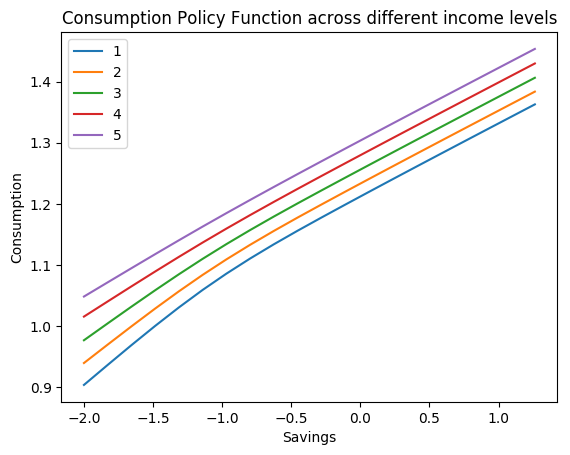

PyObject <matplotlib.text.Text object at 0x0000000027CC1128>

In [7]:
# Plot the consumption policy function across different income levels for age 1
import PyPlot
plt=PyPlot
end_y=20

for i=1:num_yplots
    plt.plot(dr_ylist[i][Axis{:V}(:s)][1:end_y],c_ylist[i][1:end_y], label=i)
end

plt.legend()
plt.xlabel("Savings")
plt.ylabel("Consumption")
plt.title("Consumption Policy Function across different income levels")

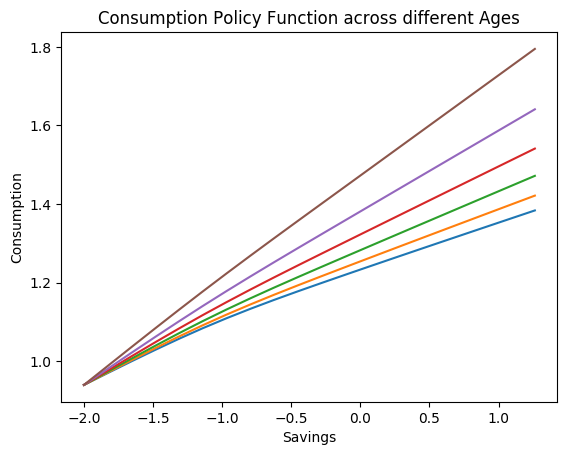

PyObject <matplotlib.text.Text object at 0x00000000280DE160>

In [8]:
# Plot consumption policy function with different ages (income level 2)
inc_level=2
a_states=convert(Vector{Int64},linspace(10,15,6))
num_aplots=length(a_states)
dr_alist=[Dolo.tabulate(model, dr, :s, s0, a) for a in a_states]
c_alist=[exp(ygrid[inc_level])+dr_alist[a][:s]*r-dr_alist[a][Axis{:V}(:a)] for a in 1:num_aplots];

for i=1:num_aplots
    plt.plot(dr_alist[i][Axis{:V}(:s)][1:end_y],c_alist[i][1:end_y], label=i)
end

plt.xlabel("Savings")
plt.ylabel("Consumption")
plt.title("Consumption Policy Function across different Ages")

Simulate the model.

In [9]:
T=10
hor=linspace(1,T,T)
mc_ar=model.exogenous
sim_armc = Dolo.simulate(model,dr,mc_ar;N=100,T=10);


 Set-up the life-status and earnings path for the agents

In [10]:
N=100
T=10

life_grid=ones(num_ages)
life_grid[num_ages]=0.0
income_path=zeros(T,N)
life_status=zeros(T,N)
age_status=zeros(T,N)
Tot_states=54.0 #(9 ages * 6 income states)
for j=1:N
    for i=1:T
       state=convert(Int64,sim_armc[Axis{:N}(j), Axis{:V}(:mc_process)][i])
       state_y,state_a=Dolo.node(model.exogenous,state)
       income_path[i,j]=exp(state_y)
       life_status[i,j]=state_a
    end
end

Plot the life-cycle consumption and income profile for one agent.

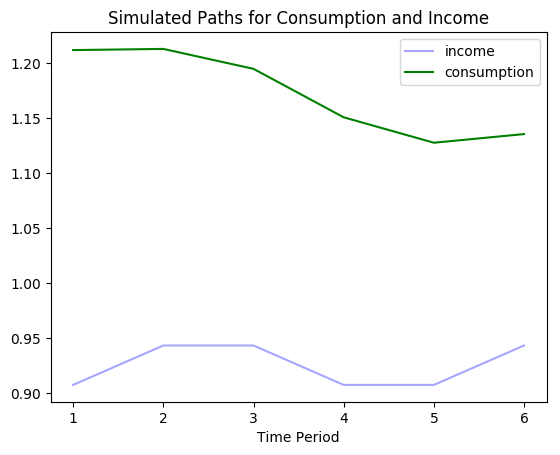

PyObject <matplotlib.text.Text object at 0x0000000027F83908>

In [11]:
# Pick an agent from the simulation: 
import PyPlot
plt=PyPlot
j=9
t_death=maximum(find(life_status[:,j]))
horizon=t_death-2
hor_alive=linspace(1,horizon,horizon)

c=(income_path[1:horizon,j]+sim_armc[Axis{:N}(j), Axis{:V}(:s)][1:horizon]*r-sim_armc[Axis{:N}(j), Axis{:V}(:a)][1:horizon]).*life_status[1:horizon,j]
plt.plot(hor_alive, income_path[1:horizon,j].*life_status[1:horizon,j], color="blue", alpha=0.35, label="income")
plt.plot(hor_alive, c, color="green",label="consumption")
plt.legend()
plt.xlabel("Time Period")
plt.title("Simulated Paths for Consumption and Income")